In [8]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

import shap

from utils import plot_pca

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv('../data/EDD_isoprenol_production.csv', index_col=0)
df.drop('Measurement Type', axis=1, inplace=True)

# Split the data into X and y
X = df.drop('Value', axis=1).copy()
y = df['Value'].copy()

df.head()

,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
Line Name,,,,,,,,,
Strain 1,0.000000,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0
Strain 2,0.552101,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0
Strain 3,0.349196,1.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0
Strain 4,0.551849,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0
Strain 5,0.080117,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0


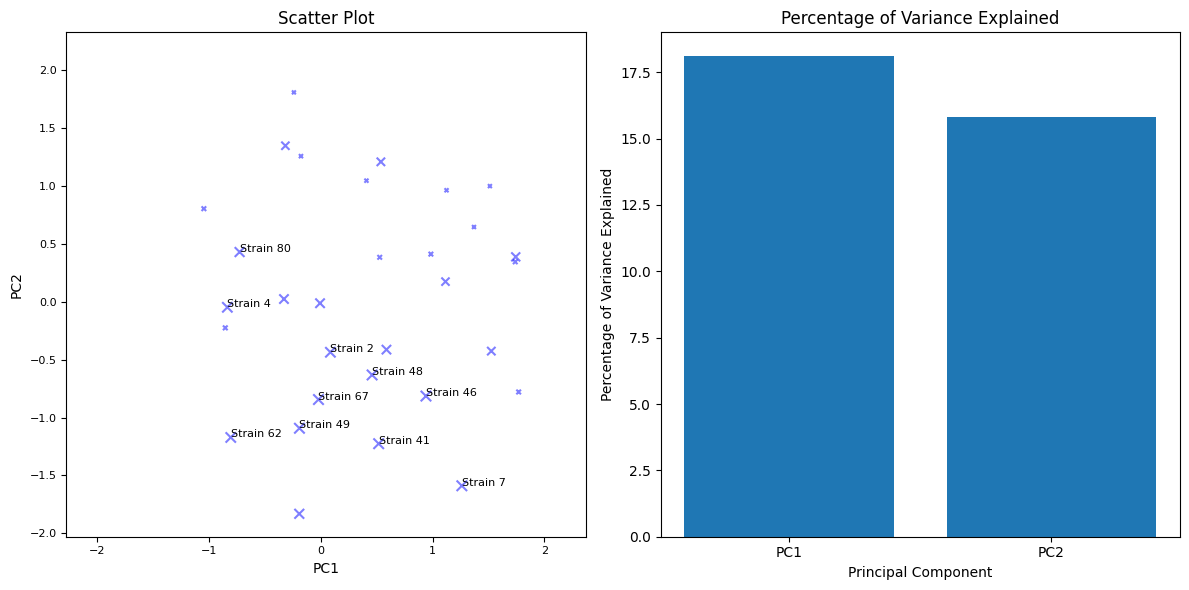

In [3]:
# Perfrom PCA on the data
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df.drop('Value', axis=1)), index=df.index, columns=['PC1', 'PC2'])
pca_df.index = df.index
pca_df['Value'] = df['Value']

# Plot the PCA
plot_pca(pca_df, pca)

0.03521519100793881
0.0009127083939047795


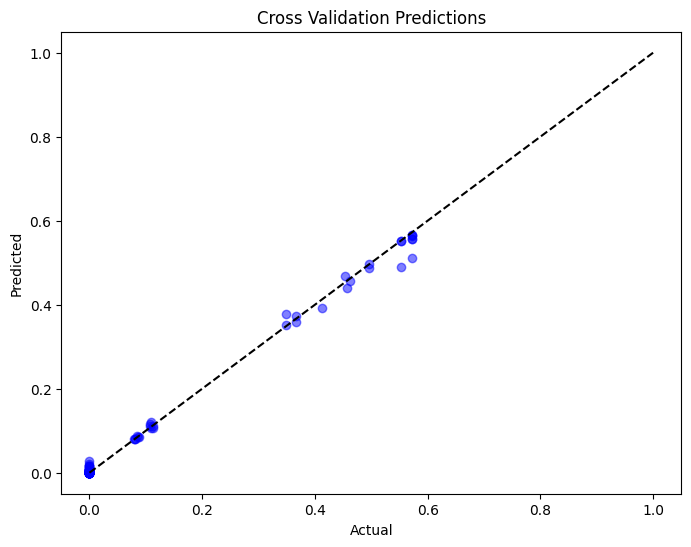

In [10]:
# Cross validate a Linear Regression model on the data
def train(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    print(np.sqrt(np.abs(scores.mean())))
    print(scores.std())
    model.fit(X, y)
    return model

def plot_R2(model, X, y):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y, model.predict(X), color='blue', alpha=0.5)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Cross Validation Predictions')
    plt.show()

rf = train(RandomForestRegressor(), X, y)
plot_R2(rf, X, y)

In [25]:
def shap_plots(model, X):
    # Calculate SHAP values and plot
    explainer = shap.Explainer(model.predict, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type='bar')
    shap.summary_plot(shap_values, X, plot_type='dot')
    # shap.plots.heatmap(shap_values)
    # shap.plots.heatmap(shap_values, feature_values=shap_values.abs.max(0))
    order = np.argsort(model.predict(X))
    shap.plots.heatmap(shap_values, instance_order=order)
    # shap.plots.heatmap(shap_values, instance_order=order, feature_values=shap_values.abs.max(0))
    return shap_values

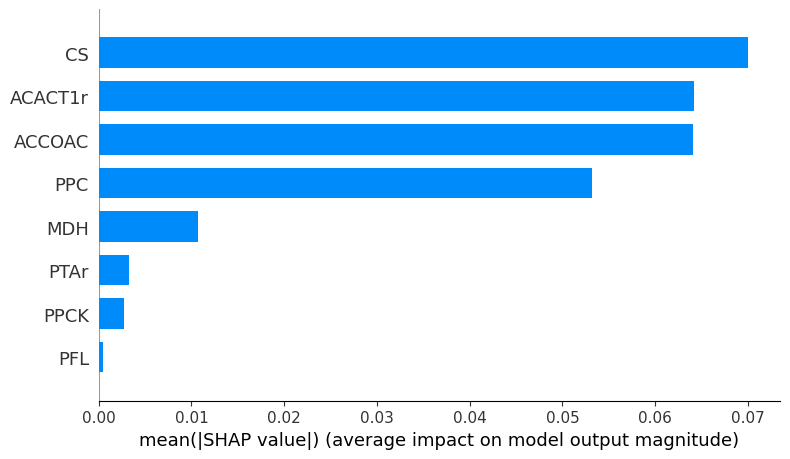

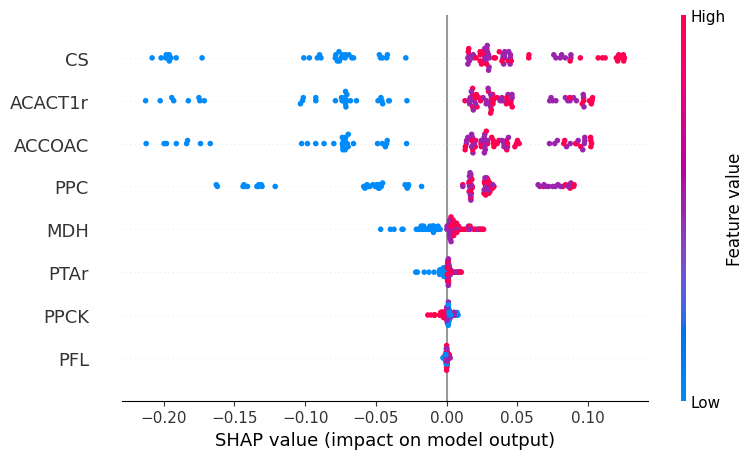

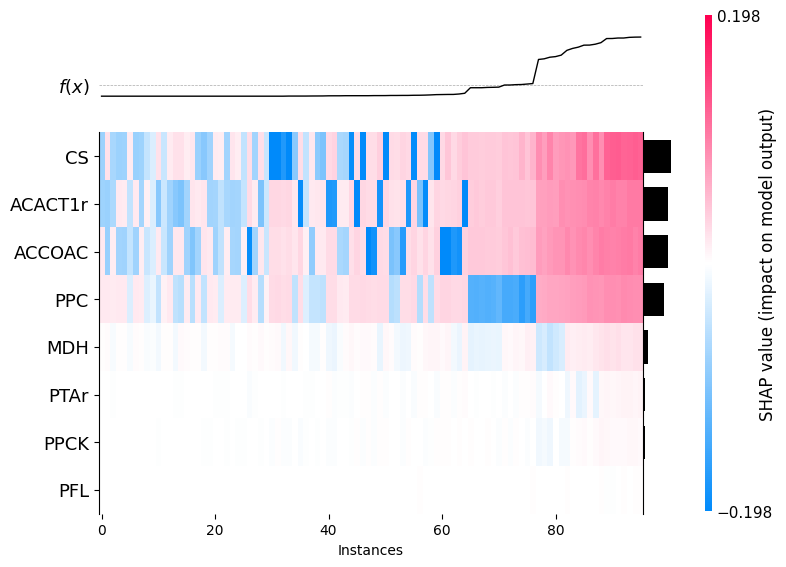

In [26]:
shap_values = shap_plots(rf, X)

In [33]:
pd.DataFrame(shap_values.data)

,0,1,2,3,4,5,6,7
0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0
1,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0
2,1.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0
3,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0
4,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
91,0.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0
92,1.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0
93,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0
94,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0
